In [1]:
!pip install transformers datasets evaluate torch torchvision huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    SegformerForSemanticSegmentation,
    AutoImageProcessor,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)

image_dir = "./drive/MyDrive/dataset/JPEGImages"
mask_dir = "./drive/MyDrive/dataset/SegmentationClass"
output_dir = "./segformer_model"

class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, processor, label_mapping, size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_paths = sorted(os.listdir(image_dir))
        self.mask_paths = sorted(os.listdir(mask_dir))
        self.processor = processor
        self.label_mapping = label_mapping
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_paths[idx])
        image = Image.open(image_path).convert("RGB")
        image = image.resize(self.size)
        mask = np.array(Image.open(mask_path))
        mask = self._map_labels(mask)
        mask = Image.fromarray(mask).resize(self.size, resample=Image.NEAREST)
        mask = np.array(mask)

        encoded_inputs = self.processor(images=image, masks=mask, return_tensors="pt")
        image_tensor = encoded_inputs['pixel_values'].squeeze(0)  # Shape should now be [3, 512, 512]
        mask_tensor = torch.tensor(mask, dtype=torch.long)  # Shape [512, 512] (single channel)
        encoded_inputs["labels"] = mask_tensor
        return {'pixel_values': image_tensor, 'labels': encoded_inputs["labels"]}

    def _map_labels(self, mask):
        mapped_mask = np.zeros_like(mask[..., 0], dtype=np.uint8)
        for idx, color in self.label_mapping.items():
            mapped_mask[(mask == color).all(axis=-1)] = idx
        return mapped_mask


# label mappings
label_mapping = {
    0: [0, 0, 0],
    1: [102, 255, 102],
    2: [250, 50, 83],
    3: [250, 250, 55],
}

processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
train_dataset = CustomSegmentationDataset(image_dir, mask_dir, processor, label_mapping)
val_dataset = CustomSegmentationDataset(image_dir, mask_dir, processor, label_mapping)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=4,
    id2label={i: f"label_{i}" for i in range(4)},
    label2id={f"label_{i}": i for i in range(4)},
    ignore_mismatched_sizes=True
)

training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    seed=42,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DefaultDataCollator(),
)

trainer.train()

model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)
print(f"Model and processor saved to {output_dir}")


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([4, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.preprocess` and were ignored: 'masks'
  return func(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.465100,0.422627
2,0.270600,0.248567
3,0.190100,0.158732
4,0.128000,0.119658
5,0.110800,0.099465
6,0.099200,0.083595
7,0.082500,0.072859
8,0.074000,0.068017
9,0.064000,0.060653
10,0.061100,0.056224


/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.preprocess` and were ignored: 'masks'
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.preprocess` and were ignored: 'masks'
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.preprocess` and were ignored: 'masks'
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.preprocess` and were ignored: 'masks'
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/utils/depre

Model and processor saved to ./segformer_model


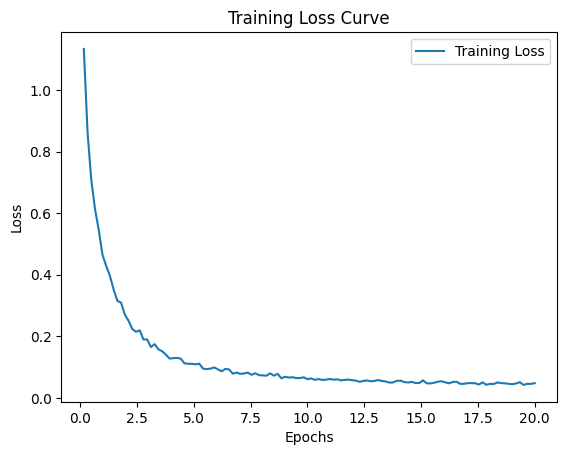

In [5]:
import matplotlib.pyplot as plt

train_loss = trainer.state.log_history
epochs = [entry['epoch'] for entry in train_loss if 'loss' in entry]
losses = [entry['loss'] for entry in train_loss if 'loss' in entry]

plt.plot(epochs, losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


In [6]:
!zip -r segformer_model.zip ./segformer_model/

  adding: segformer_model/ (stored 0%)
  adding: segformer_model/checkpoint-1159/ (stored 0%)
  adding: segformer_model/checkpoint-1159/rng_state.pth (deflated 25%)
  adding: segformer_model/checkpoint-1159/trainer_state.json (deflated 82%)
  adding: segformer_model/checkpoint-1159/model.safetensors (deflated 7%)
  adding: segformer_model/checkpoint-1159/training_args.bin (deflated 52%)
  adding: segformer_model/checkpoint-1159/scheduler.pt (deflated 55%)
  adding: segformer_model/checkpoint-1159/config.json (deflated 58%)
  adding: segformer_model/checkpoint-1159/optimizer.pt (deflated 8%)
  adding: segformer_model/checkpoint-1220/ (stored 0%)
  adding: segformer_model/checkpoint-1220/rng_state.pth (deflated 25%)
  adding: segformer_model/checkpoint-1220/trainer_state.json (deflated 82%)
  adding: segformer_model/checkpoint-1220/model.safetensors (deflated 7%)
  adding: segformer_model/checkpoint-1220/training_args.bin (deflated 52%)
  adding: segformer_model/checkpoint-1220/scheduler